In [ ]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases #Package for database reading.
!pip install mne #The MNE Package is installed
FILEID = "1-bPsREsUCOiJHzIqi8DQrfSjTAf5VAW_"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.
!dir

#Import

In [ ]:
from google.colab.drive import mount
import numpy as np
from pickle import load as pload
from MI_EEG_ClassMeth.utils import custom_indexing_list, min_max_normalization
from scipy.stats import zscore
from gcpds.databases import GIGA_MI_ME
from mne.channels import make_standard_montage
from mne import create_info
import os
import matplotlib.pyplot as plt
from mne.viz import plot_topomap
from scipy.stats import gaussian_kde
from scipy.spatial.distance import squareform
from mne.channels.layout import _find_topomap_coords
from joblib import load as jload
from math import floor, ceil
from sklearn.cluster import KMeans
import matplotlib as mpl
from MI_EEG_ClassMeth.FeatExtraction import Power_based_Connectivities
from pickle import dump as pdump

#Mount Drive

In [ ]:
mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Functions

In [ ]:
def ica_channels_contribution(subjects, ica_results_dir, noise=True):
    W_ = []
    for sbj in subjects:
        with open(ica_results_dir + 'sbj' + str(sbj) + '.txt', 'rb') as f:
            results_ica = pload(f)
        W = results_ica['W_unmixing']
        idx_noise_trials = results_ica['idx_noise_trials']
        if noise:
            W_ = W_ + custom_indexing_list(W, idx_noise_trials)
        else:
            idx_trials = np.setdiff1d(np.arange(len(W)), idx_noise_trials, assume_unique=True)
            W_ = W_ + custom_indexing_list(W, idx_trials)

    W_ = np.abs(np.concatenate(W_, axis=0))
    W_ = min_max_normalization(W_)
    median = np.median(W_, axis=0)
    q25, q75 = np.percentile(W_, [25, 75], axis=0)
    return median, q25, q75

In [ ]:
def ica_rho(subjects, ica_results_dir):
    z_rho = []
    for sbj in subjects:
        with open(ica_results_dir + 'sbj' + str(sbj) + '.txt', 'rb') as f:
            results_ica = pload(f)
        rho = results_ica['rho']
        z_rho.append(zscore(rho, axis=1))

    z_rho = np.concatenate(z_rho, axis=0)
    return z_rho

In [ ]:
def ica_noise_trials_ratio(subjects, ica_results_dir):
    noise_trials_ratio = np.zeros(subjects.shape[0])
    for i, sbj in enumerate(subjects):
        with open(ica_results_dir + 'sbj' + str(sbj) + '.txt', 'rb') as f:
            results_ica = pload(f)
        noise_trials_ratio[i] = 100*results_ica['idx_noise_trials'].shape[0]/results_ica['rho'].shape[0]
    return noise_trials_ratio

In [ ]:
def read_CV_results(subjects, cross_val_results_dir, metric):
  results = []
  for sbj in subjects:
    with open(cross_val_results_dir + 'sbj' + str(sbj) + '.txt', 'rb') as f:
        cv_results = pload(f)
    results.append(cv_results[metric])
  return np.asarray(results)

In [ ]:
def read_CV_models(subjects, models_dir, best_params):
  models = []
  if len(best_params) == 1:
    best_params = best_params*subjects.shape[0]
  for sbj, idx_best_params in zip(subjects, best_params):
    clf = jload(models_dir + idx_best_params + '/' + 'sbj' + str(sbj) + '.joblib')
    models.append(clf.coef_)
  return np.asarray(models)

#Results

Global variables to carry out results analysis.

In [ ]:
results_dir = '/content/drive/Shareddrives/GCPDS/users/Mateo/GIGA_MI_ME_preprocessing/results/'

db = GIGA_MI_ME()
fs = db.metadata['sampling_rate']
subjects = np.arange(db.metadata['subjects']) + 1
subjects = np.delete(subjects,[28,33])
eeg_ch_names = ['Fp1','Fpz','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
            'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
            'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']
n_eeg_chs = len(eeg_ch_names)
eog_ch_names = ['Fp1','Fpz','Fp2']
montage = make_standard_montage(db.metadata['montage'])
info = create_info(eeg_ch_names, fs, len(eeg_ch_names)*['eeg'])
info.set_montage(montage)

seed=23

pbc = Power_based_Connectivities()
type_con  = 'gfc' #Connectivity to carry out analysis of results

## ICA

os.makedirs('/content/drive/Shareddrives/GCPDS/users/Mateo/GIGA_MI_ME_preprocessing/results/ica/images/')

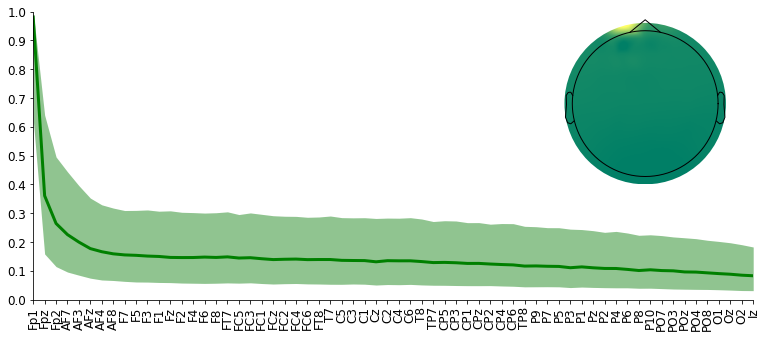

In [ ]:
fig = plt.figure(figsize=(10,4))

median, q25, q75 = ica_channels_contribution(subjects, results_dir + 'ica/', noise=True)
axs1 = fig.add_axes([0, 0, 1, 1])
axs1.fill_between(np.arange(n_eeg_chs), q25, q75, alpha=.5, color='forestgreen', linewidth=0)
axs1.plot(median,  color='green', linewidth=3)
axs1.spines['right'].set_visible(False)
axs1.spines['top'].set_visible(False)
axs1.set_ylim([0,1])
axs1.set_xlim([0 ,n_eeg_chs-1])
axs1.set_yticks(np.linspace(0,1,11))
axs1.set_yticklabels(np.round(np.linspace(0,1,11), 1), fontsize=12)
axs1.set_xticks(np.arange(n_eeg_chs))
axs1.set_xticklabels(eeg_ch_names, fontsize=12, rotation=90)
#axs1.set_ylabel('Normalized Channels-Noise Ratio', fontfamily='serif', fontsize=22, weight=500)
#axs1.set_xlabel('Channels', fontfamily='serif', fontsize=22, weight=500)

axs2 = fig.add_axes([0.55, 0.4, 0.6, 0.6])
im, _ = plot_topomap(min_max_normalization(median), pos=info, vmin=0, vmax=1, cmap='summer', axes=axs2, contours=0, sensors=False, show=False)
plt.savefig(results_dir + 'ica/images/' + 'normalized_channels_noise_ratio.pdf',format='pdf', bbox_inches='tight')

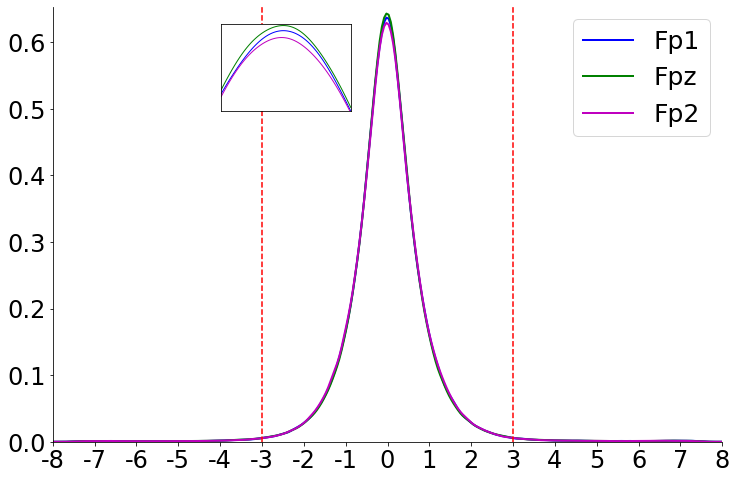

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
aux_axs = fig.add_axes([0.32,0.7,0.15,0.15])

z_rho = ica_rho(subjects, results_dir + 'ica/')
xmin = int(z_rho.min()) 
xmax = int(z_rho.max())
xmin = xmin if xmin <= -3 else -3
xmax = xmax if xmax >= 3 else 3
xmin -=1
xmax +=1

colors = ['b', 'g', 'm']

max_p = -np.inf
for i in range(z_rho.shape[-1]):
  z_rho_art = z_rho[:,:,i].ravel()
  kde = gaussian_kde(z_rho_art)
  x = np.linspace(xmin, xmax, 300)
  x_peak = np.linspace(-0.25, 0.25, 100)
  pdx = kde.pdf(x)
  max_p = max_p if max_p > pdx.max() else pdx.max()
  axs.plot(x, pdx, linewidth=2, color=colors[i], label=eog_ch_names[i])
  aux_axs.plot(x_peak, kde.pdf(x_peak), linewidth=1, color=colors[i])

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.axvline(3, clip_on = False, color='r', linestyle='dashed')
axs.axvline(-3, clip_on = False, color='r', linestyle='dashed')
axs.set_ylim([0, max_p+0.01])
axs.set_xlim([xmin, xmax])
axs.set_yticks(np.linspace(0, round(max_p, 1), 7))
axs.set_yticklabels(np.round(np.linspace(0, round(max_p, 1), 7), 1), fontsize=24)
axs.set_xticks(np.arange(xmin, xmax+1))
axs.set_xticklabels(np.arange(xmin, xmax+1), fontsize=24)
#axs.set_ylabel(r'$f(\cdot)$', fontfamily='serif', fontsize=22, weight=500)
#axs.set_xlabel(r'$Z_{\rho (s,a)}$', fontfamily='serif', fontsize=22, weight=500)
axs.legend(loc='upper right', fontsize=25)

aux_axs.axes.xaxis.set_visible(False)
aux_axs.axes.yaxis.set_visible(False)
aux_axs.set_ylim([max_p-0.1, max_p+0.002])
aux_axs.set_xlim([-0.25, 0.25])

plt.savefig(results_dir + 'ica/images/' + 'pdf_rho_s_a.pdf',format='pdf', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """


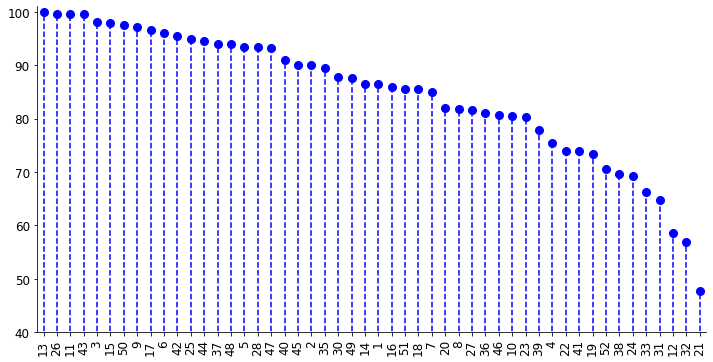

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
noise_trials_ratio = ica_noise_trials_ratio(subjects, results_dir + 'ica/')
idx_ord_noise_trials_ratio = np.argsort(noise_trials_ratio)[::-1]

markerline, stemline, baseline, = axs.stem(noise_trials_ratio[idx_ord_noise_trials_ratio], linefmt='b--', markerfmt='bo')
plt.setp(markerline, markersize = 8)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_ylim([10*floor(noise_trials_ratio.min()/10), 10*ceil(noise_trials_ratio.max()/10)+1])
axs.set_xlim([-0.5, subjects.shape[0]-0.5])
axs.set_yticks(np.linspace(10*floor(noise_trials_ratio.min()/10), 10*ceil(noise_trials_ratio.max()/10), 7, dtype=np.uint16))
axs.set_yticklabels(np.linspace(10*floor(noise_trials_ratio.min()/10), 10*ceil(noise_trials_ratio.max()/10), 7, dtype=np.uint16), fontsize=12)
axs.set_xticks(np.arange(subjects.shape[0]))
axs.set_xticklabels(subjects[idx_ord_noise_trials_ratio], fontsize=12, rotation=90)
#axs.set_ylabel('(%) Noise trials', fontfamily='serif', fontsize=22, weight=500)
#axs.set_xlabel('Subjects', fontfamily='serif', fontsize=22, weight=500)
plt.savefig(results_dir + 'ica/images/' + 'porcentage_noise_trials.pdf',format='pdf', bbox_inches='tight')

## Lapacian Filter

os.makedirs('/content/drive/Shareddrives/GCPDS/users/Mateo/GIGA_MI_ME_preprocessing/results/sl/images/')

In [ ]:
data_dir = '/content/drive/Shareddrives/GCPDS/users/Mateo/GIGA_MI_ME_preprocessing/data/'

C_xx_raw = np.zeros(int(n_eeg_chs*(n_eeg_chs-1)*0.5))
C_xx_ica_sl = np.zeros(int(n_eeg_chs*(n_eeg_chs-1)*0.5))
# ------------------------------------------------------------------------------

for sbj in subjects:
  X_raw = np.load(data_dir + 'none_none/sbj'  + str(sbj) + '.npy')
  X_ica_sl = np.load(data_dir + 'ica_sl/sbj'  + str(sbj) + '.npy')
  C_xx_raw = C_xx_raw + np.sum(pbc.transform(X_raw, type_con='pearson'), axis=(0,2,3))
  C_xx_ica_sl = C_xx_ica_sl + np.sum(pbc.transform(X_ica_sl, type_con='pearson'), axis=(0,2,3))

C_xx_raw = squareform(C_xx_raw)
C_xx_ica_sl = squareform(C_xx_ica_sl)

In [ ]:
C_xx_raw_norm = min_max_normalization(C_xx_raw.copy(), axis=1)
C_xx_ica_sl_norm = min_max_normalization(C_xx_ica_sl.copy(), axis=1)

for ch in range(n_eeg_chs):
  C_xx_raw_norm[ch,ch] = 1
  C_xx_ica_sl_norm[ch,ch] = 1

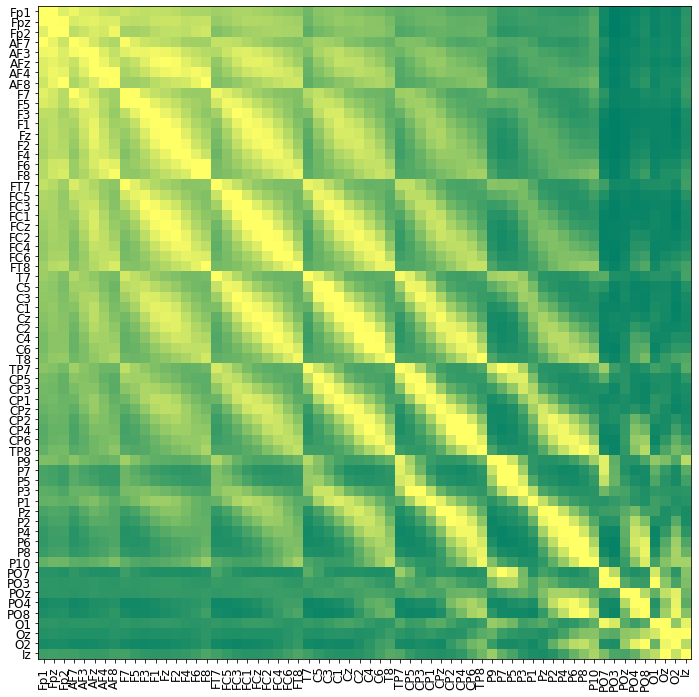

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

axs.imshow(C_xx_raw_norm, cmap='summer')
axs.set_yticks(np.arange(n_eeg_chs))
axs.set_yticklabels(eeg_ch_names, fontsize=12)
axs.set_xticks(np.arange(n_eeg_chs))
axs.set_xticklabels(eeg_ch_names,  rotation=90, fontsize=12)
plt.savefig(results_dir + 'sl/images/' + 'none_none_C_xx.pdf',format='pdf', bbox_inches='tight')

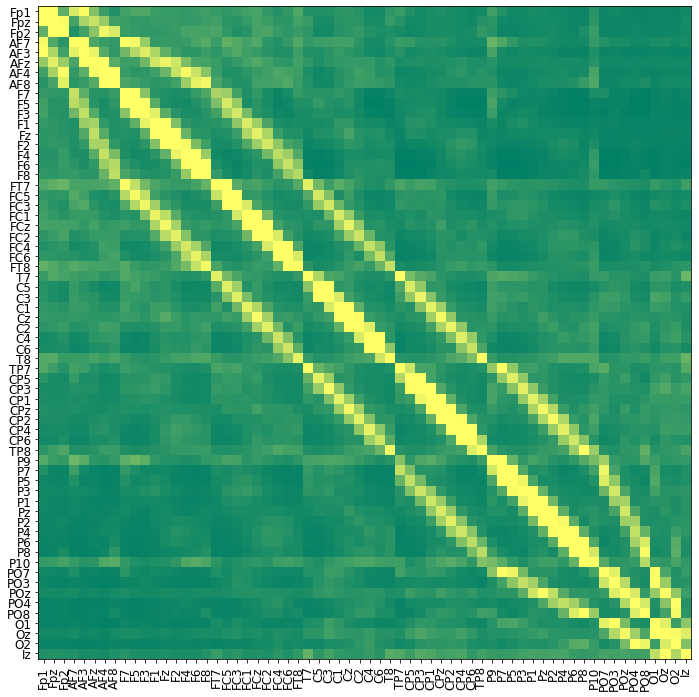

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

axs.imshow(C_xx_ica_sl_norm, cmap='summer')
axs.set_yticks(np.arange(n_eeg_chs))
axs.set_yticklabels(eeg_ch_names, fontsize=12)
axs.set_xticks(np.arange(n_eeg_chs))
axs.set_xticklabels(eeg_ch_names,  rotation=90, fontsize=12)
plt.savefig(results_dir + 'sl/images/' + 'ica_sl_C_xx.pdf',format='pdf', bbox_inches='tight')

In [ ]:
idx_ch = eeg_ch_names.index('Cz')
C_xx_raw_ch = C_xx_raw[idx_ch,:].copy()
C_xx_raw_ch = min_max_normalization(C_xx_raw_ch, axis=None)
C_xx_raw_ch[idx_ch] = 1

C_xx_ica_sl_ch = C_xx_ica_sl[idx_ch,:].copy()
C_xx_ica_sl_ch = min_max_normalization(C_xx_ica_sl_ch, axis=None)
C_xx_ica_sl_ch[idx_ch] = 1

In [ ]:
pos = _find_topomap_coords(info, picks=None)
pos = pos[:, :2]
pos_x, pos_y = pos.T

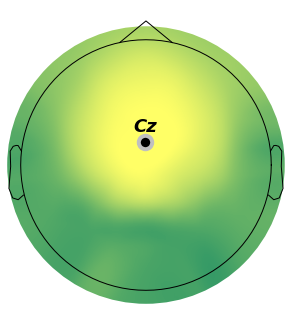

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

plot_topomap(C_xx_raw_ch, pos=info, vmin=0, vmax=1, cmap='summer', contours=0, axes=axs, sensors=False, show=False)
axs.scatter(pos[idx_ch,0], pos[idx_ch,1], s=180, color='k', edgecolors='silver', linewidths=4)
axs.annotate(eeg_ch_names[idx_ch], xy=pos[idx_ch,:], xytext=(0,10), textcoords="offset points", fontsize=18, fontstyle='italic', fontweight='bold', ha='center')
plt.savefig(results_dir + 'sl/images/' + 'none_none_C_xx_Cz.pdf',format='pdf', bbox_inches='tight')

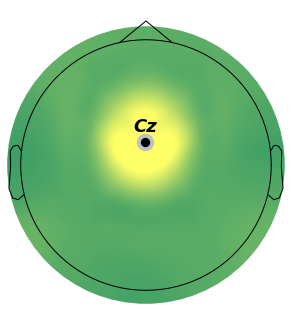

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

plot_topomap(C_xx_ica_sl_ch, pos=info, vmin=0, vmax=1, cmap='summer', contours=0, axes=axs, sensors=False, show=False)
axs.scatter(pos[idx_ch,0], pos[idx_ch,1], s=180, color='k', edgecolors='silver', linewidths=4)
axs.annotate(eeg_ch_names[idx_ch], xy=pos[idx_ch,:], xytext=(0,10), textcoords="offset points", fontsize=18, fontstyle='italic', fontweight='bold', ha='center')
plt.savefig(results_dir + 'sl/images/' + 'ica_sl_C_xx_Cz.pdf',format='pdf', bbox_inches='tight')

In [ ]:
f_raw = np.sum(C_xx_raw, axis=1)
f_raw = min_max_normalization(f_raw, axis=None)
f_ica_sl = np.sum(C_xx_ica_sl, axis=1)
f_ica_sl = min_max_normalization(f_ica_sl, axis=None)

(<matplotlib.image.AxesImage at 0x7f06ba147290>, None)

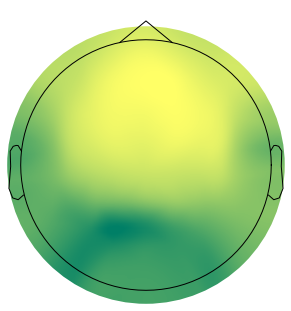

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

plot_topomap(f_raw , pos=info, vmin=0, vmax=1, cmap='summer', contours=0, axes=axs, sensors=False, show=False)
#plt.savefig(results_dir + 'sl/images/' + 'none_none_normalized_flow_of_C_xx.pdf',format='pdf', bbox_inches='tight')

(<matplotlib.image.AxesImage at 0x7f06ba147350>, None)

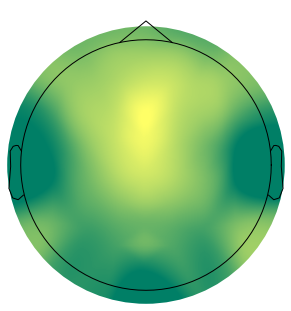

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

plot_topomap(f_ica_sl , pos=info, vmin=0, vmax=1, cmap='summer', contours=0, axes=axs, sensors=False, show=False)
#plt.savefig(results_dir + 'sl/images/' + 'ica_sl_normalized_flow_of_C_xx.pdf',format='pdf', bbox_inches='tight')

In [ ]:
idx_no_SMR_chs = ['Fp1','Fpz','Fp2',
            'AF7','AF3','AFz','AF4','AF8',
            'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
            'FT7','FT8',
            'T7','T8',
            'TP7','TP8',
            'P9','P7','P5','P3','P1','Pz','P2','P4','P6','P8','P10',
            'PO7','PO3','POz','PO4','PO8',
            'O1','Oz','O2',
            'Iz']

f_raw_SMR = f_raw.copy()
f_ica_sl_SMR = f_ica_sl.copy()

for ch in idx_no_SMR_chs:
  idx = eeg_ch_names.index(ch)
  f_raw_SMR[idx] = 0
  f_ica_sl_SMR[idx] = 0 

(<matplotlib.image.AxesImage at 0x7f06ba3617d0>, None)

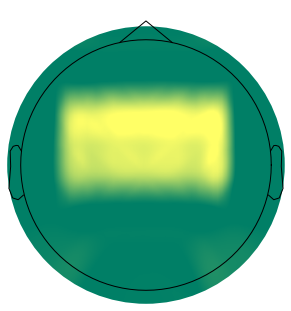

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

plot_topomap(f_raw_SMR, pos=info, vmin=0, vmax=1, cmap='summer', contours=0, axes=axs, sensors=False, show=False)
#plt.savefig(results_dir + 'sl/images/' + 'none_none_normalized_flow_of_C_xx_SMR.pdf',format='pdf', bbox_inches='tight')

(<matplotlib.image.AxesImage at 0x7f06ba2844d0>, None)

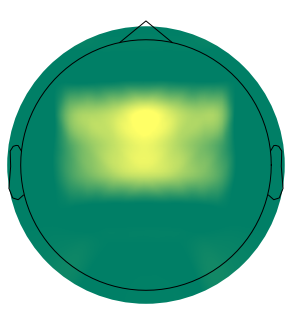

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

plot_topomap(f_ica_sl_SMR , pos=info, vmin=0, vmax=1, cmap='summer', contours=0, axes=axs, sensors=False, show=False)
#plt.savefig(results_dir + 'sl/images/' + 'ica_sl_normalized_flow_of_C_xx_SMR.pdf',format='pdf', bbox_inches='tight')

## Metrics

In [ ]:
connectivities = ['plv', 'coh', 'pearson', 'motif', 'gfc']
metrics = ['acc', 'kappa', 'auc']
round = [1,2,2]

results = {} #{'C_xx':{'metric':{'Raw':, 'ICA+SL', 'prposed'}}}
comparison_results_all_sbjs = {m:[] for m in metrics} #{'metric': array \in {sbjs by C_xx, {NONE, ICA+SL, proposed}}}
for t_con in connectivities:
  metrics_C_xx = {}
  for m, r in zip(metrics, round):
    score = read_CV_results(subjects, results_dir + 'hyparam_tuning/' + t_con + '/', 'mean_test_'+m) # score \in {sbjs, {NONE, SL, ICA, ICA+SL}}
    score_tuning_preprocessing = np.max(score, axis=1) # {sbjs, proposed}
    comparison_results = np.stack([score[:,0], score[:,-1], score_tuning_preprocessing], axis=1) # score_results \in {sbjs, {NONE, ICA+SL, proposed}}
    comparison_results_all_sbjs[m].append(comparison_results)
    mean = np.round(comparison_results.mean(axis=0), r)
    std =  np.round(comparison_results.std(axis=0), r)
    metrics_C_xx[m] = {'Raw':[mean[0], std[0]], 'SL+ICA':[mean[1], std[1]], 'proposed':[mean[2], std[2]]}
  results[t_con] = metrics_C_xx

for m in comparison_results_all_sbjs.keys():
  comparison_results_all_sbjs[m] = np.concatenate(comparison_results_all_sbjs[m], axis=0)

global_metrics = {}

for m, r in zip(metrics, round):
  mean = np.round(comparison_results_all_sbjs[m].mean(axis=0), r)
  std =  np.round(comparison_results_all_sbjs[m].std(axis=0), r)
  global_metrics[m] = {'Raw':[mean[0], std[0]], 'SL+ICA':[mean[1], std[1]], 'proposed':[mean[2] ,std[2]]}

results['global_results'] = global_metrics

with open(results_dir+'mean_by_sbjs_results.txt', 'wb') as f:
      pdump(results, f)

with open(results_dir+'sbjs_results.txt', 'wb') as f:
      pdump(comparison_results_all_sbjs, f)

In [ ]:
results

{'coh': {'acc': {'Raw': [64.0, 9.4],
   'SL+ICA': [63.2, 11.3],
   'proposed': [67.6, 10.6]},
  'auc': {'Raw': [0.64, 0.09],
   'SL+ICA': [0.63, 0.11],
   'proposed': [0.67, 0.11]},
  'kappa': {'Raw': [0.28, 0.19],
   'SL+ICA': [0.26, 0.23],
   'proposed': [0.35, 0.21]}},
 'gfc': {'acc': {'Raw': [70.2, 11.9],
   'SL+ICA': [70.6, 12.3],
   'proposed': [73.4, 11.6]},
  'auc': {'Raw': [0.7, 0.12], 'SL+ICA': [0.7, 0.12], 'proposed': [0.73, 0.12]},
  'kappa': {'Raw': [0.4, 0.24],
   'SL+ICA': [0.41, 0.25],
   'proposed': [0.47, 0.23]}},
 'global_results': {'acc': {'Raw': [65.2, 10.8],
   'SL+ICA': [64.6, 12.6],
   'proposed': [68.9, 11.5]},
  'auc': {'Raw': [0.65, 0.11],
   'SL+ICA': [0.64, 0.13],
   'proposed': [0.69, 0.12]},
  'kappa': {'Raw': [0.3, 0.22],
   'SL+ICA': [0.29, 0.25],
   'proposed': [0.37, 0.23]}},
 'motif': {'acc': {'Raw': [64.5, 10.4],
   'SL+ICA': [63.7, 12.5],
   'proposed': [68.3, 11.6]},
  'auc': {'Raw': [0.64, 0.1],
   'SL+ICA': [0.63, 0.13],
   'proposed': [0.68, 0.



## Group Analysis

os.makedirs('/content/drive/Shareddrives/GCPDS/users/Mateo/GIGA_MI_ME_preprocessing/results/group_analysis/')

In [ ]:
metrics = ['acc', 'kappa', 'auc']
score_mean = []
score_std = []
for metric in metrics:
  score_mean.append(read_CV_results(subjects, results_dir + 'hyparam_tuning/' + type_con +'/', 'mean_test_'+metric))
  score_std.append(read_CV_results(subjects, results_dir + 'hyparam_tuning/' + type_con +'/', 'std_test_'+metric))
score_mean = np.stack(score_mean, axis=0)
score_std = np.stack(score_std, axis=0)
score = np.concatenate([score_mean, score_std], axis=0) # {{ACC, KAPPA, AUC, std ACC, std, KAPPA, std AUC}, Sbjs, {RAW, SL, ICA, ICA+SL}}

In [ ]:
reference = score[:,:,0].T # RAW \in {{ACC, KAPPA, AUC, std ACC, std, KAPPA, std AUC}, Sbjs}
idx_ord_sbj = np.argsort(reference[:,0])[::-1] #subjects descendetnt order based in acc of Raw
n_groups = 3

kmeans = KMeans(n_clusters=n_groups, random_state=seed).fit(reference) #groups based in mean +\- std of all metrics for raw preprocessing stage
groups = np.argsort(kmeans.cluster_centers_[:,0])[::-1] #idx groups descending order

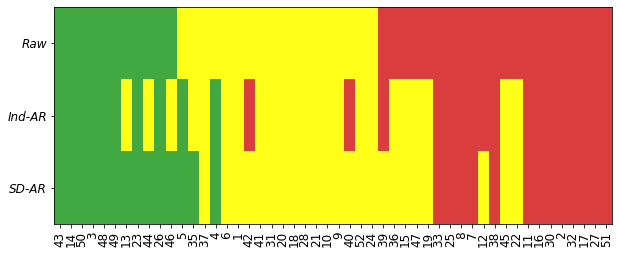

In [ ]:
# Groups Varibiality

grs_raw = kmeans.predict(score[:,:,0].T) #groups raw \in {Sbsj}
grs_ica_sl = kmeans.predict(score[:,:,-1].T) #groups ica+sl \in {Sbsj}
grs_prop = kmeans.predict(np.max(score, axis=-1).T) #groups proposal \in {Sbsj}

comparison_grs = np.stack([grs_raw, grs_ica_sl, grs_prop], axis=0)
comparison_grs = comparison_grs[:,idx_ord_sbj] # {groups{RAW, ICA+SL, proposal}, Sbsj}

colors = ['yellow', 'tab:red', 'tab:green']
cmap = mpl.colors.ListedColormap(colors)

fig = fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

_ = axs.imshow(comparison_grs, aspect='auto', cmap=cmap, alpha=0.9)
_ = axs.set_yticks(np.arange(n_groups))
_ = axs.set_yticklabels(['Raw', 'Ind-AR', 'SD-AR'], fontsize=12, style='italic')
_ = axs.set_xticks(np.arange(subjects.shape[0]))
_ = axs.set_xticklabels(subjects[idx_ord_sbj], fontsize=12, rotation=90)
plt.savefig(results_dir + 'group_analysis/' + 'comparison_groups', format='pdf', bbox_inches='tight')

In [ ]:
# Number of subjects in the groups for each preprocessing stage.

n_sbjs_group = np.zeros((n_groups, 3))
for i, gr_id in enumerate(groups):
  n_sbjs_group[0,i] = np.sum(grs_raw == gr_id)
  n_sbjs_group[1,i] = np.sum(grs_ica_sl == gr_id)
  n_sbjs_group[2,i] = np.sum(grs_prop == gr_id)

In [ ]:
n_sbjs_group

array([[11., 18., 21.],
       [10., 23., 17.],
       [14., 23., 13.]])

In [ ]:
# G.I, include 3 subjects of middle group
# G.II, include 8 subjects of the bad group

In [ ]:
results_groups = {}
for i, gr_id in enumerate(groups):
  idx = grs_raw == gr_id
  score_group = score[0:3, idx, :] # score_group \in {{ACC, KAPPA, AUC}, sbjs, {NONE, SL, ICA, ICA+SL}}
  score_tuning_preprocessing_group = np.max(score_group, axis=-1) # score_tuning_preprocessing_group \in {{ACC, KAPPA, AUC}, sbjs}
  comparison_results_group = np.stack([score_group[:,:,0], score_group[:,:,-1], score_tuning_preprocessing_group], axis=-1) # comparison_results_group \in {{ACC, KAPPA, AUC}, sbjs, {NONE, ICA+SL, proposed}}
  comparison_results_group_mean = np.mean(comparison_results_group, axis=1) # comparison_results_group_mean \in {{ACC, KAPPA, AUC}, {NONE, ICA+SL, proposed}}
  comparison_results_group_mean[0,:] = np.round(comparison_results_group_mean[0,:], 1) 
  comparison_results_group_mean [1:] = np.round(comparison_results_group_mean[1:,:], 2)
  comparison_results_group_std = np.std(comparison_results_group, axis=1)
  comparison_results_group_std[0,:] = np.round(comparison_results_group_std[0,:], 1) 
  comparison_results_group_std[1:] = np.round(comparison_results_group_std[1:,:], 2)
  results_groups['G'+str(i+1)] = {'acc':{'Raw':[comparison_results_group_mean[0,0], comparison_results_group_std[0,0]], 'ICA+SL':[comparison_results_group_mean[0,1], comparison_results_group_std[0,1]], 'proposal':[comparison_results_group_mean[0,2], comparison_results_group_std[0,2]]},
   'kappa':{'Raw':[comparison_results_group_mean[1,0], comparison_results_group_std[1,0]], 'ICA+SL':[comparison_results_group_mean[1,1], comparison_results_group_std[1,1]], 'proposal':[comparison_results_group_mean[1,2], comparison_results_group_std[1,2]]},
   'auc':{'Raw':[comparison_results_group_mean[2,0], comparison_results_group_std[2,0]], 'ICA+SL':[comparison_results_group_mean[2, 1], comparison_results_group_std[2,1]], 'proposal':[comparison_results_group_mean[2,2], comparison_results_group_std[2,2]]}}

In [ ]:
results_groups

{'G1': {'acc': {'ICA+SL': [85.9, 6.5],
   'Raw': [86.4, 5.5],
   'proposal': [88.3, 5.5]},
  'auc': {'ICA+SL': [0.86, 0.06],
   'Raw': [0.86, 0.06],
   'proposal': [0.88, 0.05]},
  'kappa': {'ICA+SL': [0.72, 0.13],
   'Raw': [0.73, 0.11],
   'proposal': [0.76, 0.11]}},
 'G2': {'acc': {'ICA+SL': [72.8, 7.8],
   'Raw': [73.9, 4.1],
   'proposal': [76.5, 5.9]},
  'auc': {'ICA+SL': [0.72, 0.08],
   'Raw': [0.74, 0.04],
   'proposal': [0.76, 0.06]},
  'kappa': {'ICA+SL': [0.45, 0.16],
   'Raw': [0.47, 0.08],
   'proposal': [0.52, 0.12]}},
 'G3': {'acc': {'ICA+SL': [60.6, 7.6],
   'Raw': [58.7, 5.1],
   'proposal': [63.0, 6.4]},
  'auc': {'ICA+SL': [0.61, 0.08],
   'Raw': [0.58, 0.05],
   'proposal': [0.63, 0.07]},
  'kappa': {'ICA+SL': [0.21, 0.15],
   'Raw': [0.17, 0.1],
   'proposal': [0.26, 0.13]}}}

In [ ]:
idx_best_params = np.argmax(score[0,:,:], axis=1) # idx best params {0,1,2,3} --> {RAW, SL, ICA, ICA+SL} based in ACC
params = ['none_none', 'none_sl', 'ica_none', 'ica_sl']
best_params = []
for idx_bp in idx_best_params:
  best_params.append(params[idx_bp])
best_params = np.asarray(best_params)

groups_prep_steps_perc = np.zeros((n_groups, len(params))) #{groups, {RAW, SL, ICA, ICA+SL}}
for i, gr_id in enumerate(groups):
  best_params_group = best_params[grs_raw == gr_id]
  for par_id in range(len(params)):
    groups_prep_steps_perc[i, par_id] = np.round(100*np.sum(best_params_group == params[par_id])/best_params_group.shape[0],2)

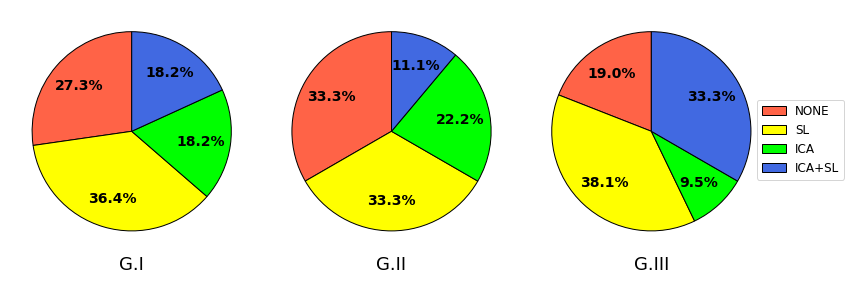

In [ ]:
# Hyper-parameter Analysis in each group

fig, axs = plt.subplots(nrows=1, ncols=n_groups, figsize=(12,8))
x_labels = ['G.I', 'G.II', 'G.III']

for i, gr_id in enumerate(groups):
  axs[i].pie(groups_prep_steps_perc[i], colors = ['tomato', 'yellow', 'lime', 'royalblue'], autopct='%1.1f%%', startangle=90, pctdistance=0.7, wedgeprops={'edgecolor':'k', 'linewidth': 1},
          textprops={'color':'k', 'weight':'bold', 'fontsize':14})
  axs[i].set_xlabel(x_labels[i], fontsize=18, labelpad=0)

axs[2].legend(bbox_to_anchor=(0.9, 0.65), labels=['NONE', 'SL', 'ICA', 'ICA+SL'], fontsize=12)
fig.tight_layout()
plt.savefig(results_dir + 'group_analysis/' + 'groups_prep_steps_perc.pdf', format='pdf', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note 

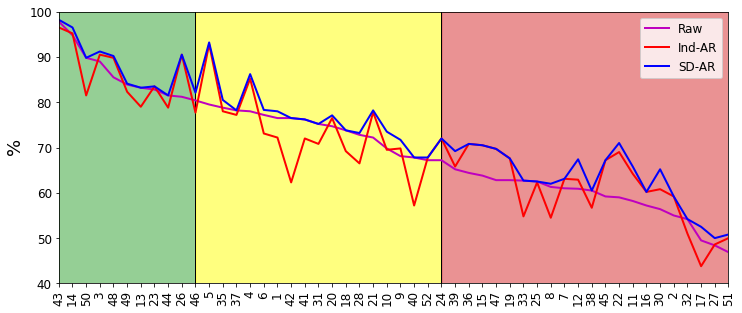

In [ ]:
# Individual subject's performance variability

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

axs.axvspan(0, n_sbjs_group[0,0]-1, alpha=0.5, color='tab:green')
axs.axvspan(n_sbjs_group[0,0]-0.99, sum(n_sbjs_group[0,:2], -1), alpha=0.5, color='yellow')
axs.axvspan(sum(n_sbjs_group[0,:2], -0.99), sum(n_sbjs_group[0], -1), alpha=0.5, color='tab:red')
axs.axvline(n_sbjs_group[0,0]-1, 0, clip_on = False, color='k', linewidth=1)
axs.axvline(sum(n_sbjs_group[0,:2], -1), 0, clip_on = False, color='k', linewidth=1)
axs.plot(score[0,:,0][idx_ord_sbj], 'm', linewidth=2, label='Raw')
axs.plot(score[0,:,-1][idx_ord_sbj],'r', linewidth=2, label='Ind-AR')
axs.plot(np.max(score[0,:,:], axis=1)[idx_ord_sbj], 'b', linewidth=2, label='SD-AR')
axs.set_ylim([score[0,:,:].min(), 100])
axs.set_xlim([0, subjects.shape[0]-1])
axs.set_yticks(np.arange(10*floor(score[0,:,:].min()/10), 101, 10, dtype=np.int))
axs.set_yticklabels(np.arange(10*floor(score[0,:,:].min()/10), 101, 10, dtype=np.int), fontsize=12)
axs.set_ylabel(r'$\%$', fontsize=18)
axs.set_xticks(np.arange(subjects.shape[0]))
axs.set_xticklabels(subjects[idx_ord_sbj], fontsize=12, rotation=90)
axs.legend(loc='upper right', fontsize=12)
plt.savefig(results_dir + 'group_analysis/' + 'groups_acc.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# Parameters for topoplots

n_c_xx = int(n_eeg_chs*(n_eeg_chs-1)*0.5)
#fb_label = [r'$\mu$', r'$\beta_{l}$', r'$\beta_{m}$', r'$\beta_{h}$']
fb_label = [r'$\mu$', r'$\beta$']
n_f_bank = len(fb_label)

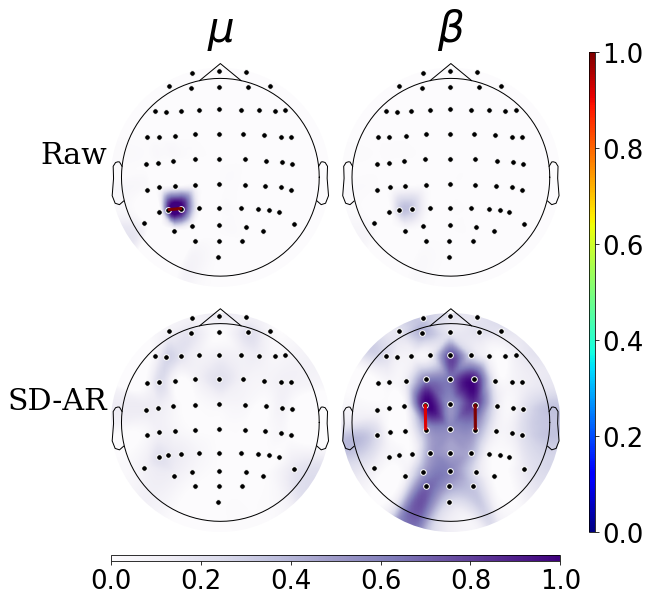

In [ ]:
#Sbj 45 Illiteracy

coef_raw = np.abs(np.squeeze(read_CV_models(np.array([45]), results_dir + 'models/' + type_con + '/', ['none_none'])))
coef_raw = coef_raw.reshape(n_c_xx, 4)
coef_raw = np.stack([coef_raw[:,0], np.max(coef_raw[:,1:], axis=1)], axis=1)
coef_prop = np.abs(np.squeeze(read_CV_models(np.array([45]), results_dir + 'models/' + type_con + '/', ['ica_sl'])))
coef_prop = coef_prop.reshape(n_c_xx, 4)
coef_prop = np.stack([coef_prop[:,0], np.max(coef_prop[:,1:], axis=1)], axis=1)
coef = np.zeros((n_c_xx, 2, n_f_bank))
coef[:,0,:] = coef_raw
coef[:,1,:] = coef_prop
coef = min_max_normalization(coef, axis=(0,2))
coef[coef < 0.2] = 0

pbc.plot_connectivities(coef.reshape(-1).copy(), info, eeg_ch_names, n_vwt=2, n_f_bank=n_f_bank, min_max_normalization_type='windows', thr=0.9,
                        w_label=['Raw', 'SD-AR'], fb_label=fb_label, labels_params = {'ylabel_fonfamily':'serif', 'ylabel_fontsize':30, 'ylabel_weight':500, 'xlabel_fonfamily':'serif', 'xlabel_fontsize':42, 'xlabel_weight':500, 'rotation':0, 'cl_size':26},
                        relevant_channels=False, plot_channels_names=False, figsize=(8,8), cmap_connectivities='jet', cmap_tplt='Purples', save=True, path=results_dir + 'group_analysis/' + 'Cxx_topoplos_sbj45_proposal', format='pdf')

In [ ]:
group_label = ['G. I', 'G. II', 'G. III']

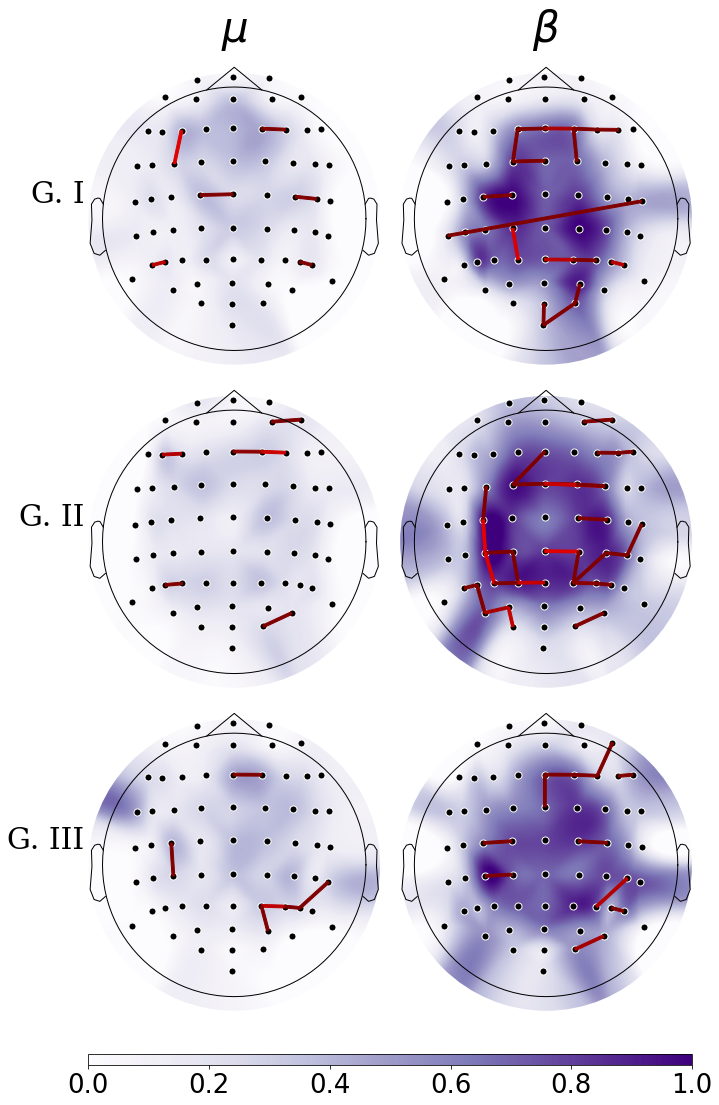

In [ ]:
#Groups Topograms Raw

coef_groups = np.zeros((n_c_xx, n_groups, n_f_bank))

for i, gr_id in enumerate(groups):
  idx = grs_prop == gr_id
  coef = read_CV_models(subjects[idx], results_dir + 'models/' + type_con + '/', ['none_none'])
  coef = np.abs(np.squeeze(coef)) # {sbjs, |C_xx_f|}
  coef = min_max_normalization(coef, axis=1) # {sbjs, |C_xx_f|}[0,1]
  coef = np.max(coef, axis=0) #Keep best C_xx of each subject in the group topopot and analize variability in freq, C_xx, long or short C_xx, etc...
  coef = coef.reshape(n_c_xx, 4) #{sbjs, |C_xx|, {u, b_l, b_m, b_h}}
  coef = np.stack([coef[:,0], np.max(coef[:,1:], axis=1)], axis=1) #{sbjs, |C_xx|, {u, b}}
  coef[coef < 0.2] = 0
  coef_groups[:,i,:] = coef
pbc.plot_connectivities(coef_groups.reshape(-1).copy(), info, eeg_ch_names, n_vwt=n_groups, n_f_bank=n_f_bank, min_max_normalization_type='windows', thr=0.9,
                        w_label=group_label, fb_label=fb_label, labels_params = {'ylabel_fonfamily':'serif', 'ylabel_fontsize':30, 'ylabel_weight':500, 'xlabel_fonfamily':'serif', 'xlabel_fontsize':42, 'xlabel_weight':500, 'rotation':0, 'cl_size':26},
                        relevant_channels=False, plot_channels_names=False, figsize=(10,15), cmap_connectivities='jet', cmap_tplt='Purples', show_connectivity_colorbar=False, save=True, path=results_dir + 'group_analysis/' + 'Cxx_topoplos_groups_raw', format='pdf')

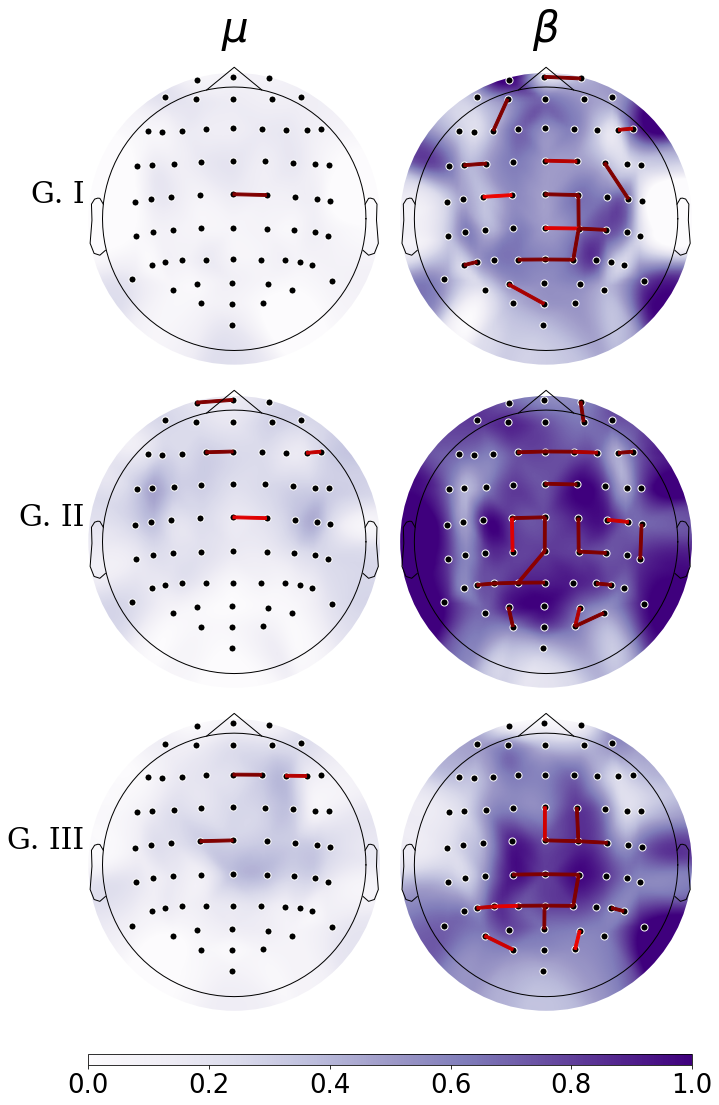

In [ ]:
#Groups Topograms ICA+SL


coef_groups = np.zeros((n_c_xx, n_groups, n_f_bank))

for i, gr_id in enumerate(groups):
  idx = grs_prop == gr_id
  coef = read_CV_models(subjects[idx], results_dir + 'models/' + type_con + '/', ['ica_sl']) # {sbjs, |C_xx_f|}
  coef = np.abs(np.squeeze(coef))
  coef = min_max_normalization(coef, axis=1)
  coef = np.max(coef, axis=0) #Keep best C_xx of each subject in the group topopot and analize variability in freq, C_xx, long or short C_xx, etc...
  coef = coef.reshape(n_c_xx, 4)
  coef = np.stack([coef[:,0], np.max(coef[:,1:], axis=1)], axis=1)
  coef[coef < 0.2] = 0
  coef_groups[:,i,:] = coef
pbc.plot_connectivities(coef_groups.reshape(-1).copy(), info, eeg_ch_names, n_vwt=n_groups, n_f_bank=n_f_bank, min_max_normalization_type='windows', thr=0.9,
                        w_label=group_label, fb_label=fb_label, labels_params = {'ylabel_fonfamily':'serif', 'ylabel_fontsize':30, 'ylabel_weight':500, 'xlabel_fonfamily':'serif', 'xlabel_fontsize':42, 'xlabel_weight':500, 'rotation':0, 'cl_size':26},
                        relevant_channels=False, plot_channels_names=False, figsize=(10,15), cmap_connectivities='jet', cmap_tplt='Purples', show_connectivity_colorbar=False, save=True, path=results_dir + 'group_analysis/' + 'Cxx_topoplos_groups_ica_sl', format='pdf')

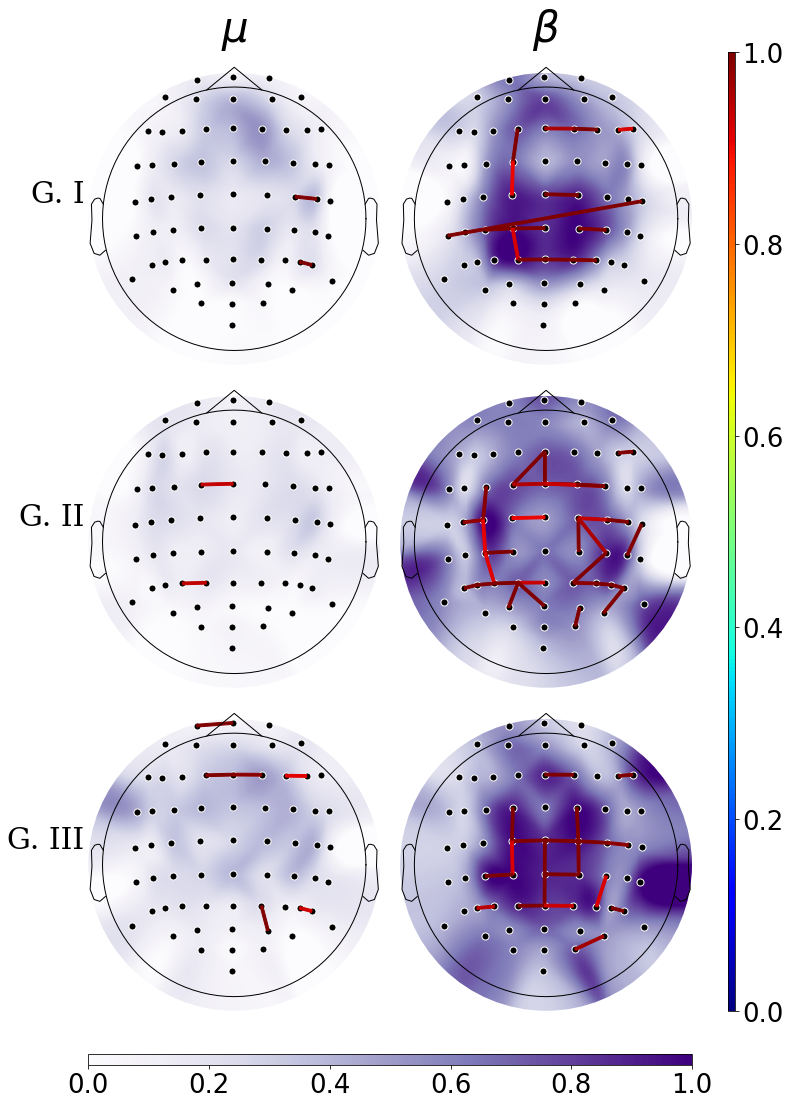

In [ ]:
#Groups Topograms proposal


coef_groups = np.zeros((n_c_xx, n_groups, n_f_bank))

for i, gr_id in enumerate(groups):
  idx = grs_raw == gr_id
  coef = read_CV_models(subjects[idx], results_dir + 'models/' + type_con + '/', best_params[idx]) # {sbjs, |C_xx_f|}
  coef = np.abs(np.squeeze(coef))
  coef = min_max_normalization(coef, axis=1)
  coef = np.max(coef, axis=0) #Keep best C_xx of each subject in the group topopot and analize variability in freq, C_xx, long or short C_xx, etc...
  coef = coef.reshape(n_c_xx, 4)
  coef = np.stack([coef[:,0], np.max(coef[:,1:], axis=1)], axis=1)
  coef[coef < 0.2] = 0
  coef_groups[:,i,:] = coef
pbc.plot_connectivities(coef_groups.reshape(-1).copy(), info, eeg_ch_names, n_vwt=n_groups, n_f_bank=n_f_bank, min_max_normalization_type='windows', thr=0.9,
                        w_label=group_label, fb_label=fb_label, labels_params = {'ylabel_fonfamily':'serif', 'ylabel_fontsize':30, 'ylabel_weight':500, 'xlabel_fonfamily':'serif', 'xlabel_fontsize':42, 'xlabel_weight':500, 'rotation':0, 'cl_size':26},
                        relevant_channels=False, plot_channels_names=False, figsize=(10,15), cmap_connectivities='jet', cmap_tplt='Purples', save=True, path=results_dir + 'group_analysis/' + 'Cxx_topoplos_groups_proposal', format='pdf')